# ov.Agent with Skills: Natural‑Language Single‑Cell Analysis (PBMC3k)

This tutorial demonstrates how to analyze PBMC3k using `ov.Agent` with project Skills. The agent auto‑discovers skills under `.claude/skills` and injects their guidance to produce better, safer code.


## Prerequisites

- omicverse installed in this environment
- pantheon-agents installed (Agent backend)
- scanpy for dataset + plotting
- Provider API key in env (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`, `GEMINI_API_KEY`)
- Skills: discovered automatically from both the installed package and your CWD at `.claude/skills/`

> Tip: `print(ov.list_supported_models())` shows supported models and required env vars.


In [3]:
import os
from pathlib import Path
import scanpy as sc
import omicverse as ov

print('OmicVerse version:', getattr(ov, '__version__', 'unknown'))
print(ov.list_supported_models())

OPENAI_API_KEY = '' + os.getenv('OPENAI_API_KEY', '')

# Nice plotting defaults
sc.settings.set_figure_params(dpi=100)

OmicVerse version: 1.7.8
🤖 Supported Models:

**Openai**:
  • `gpt-5`: OpenAI GPT-5 (Latest) ❌
  • `gpt-5-mini`: OpenAI GPT-5 Mini ❌
  • `gpt-5-nano`: OpenAI GPT-5 Nano ❌
  ... and 13 more models

**Anthropic**:
  • `anthropic/claude-opus-4-1-20250805`: Claude Opus 4.1 (Latest) ❌
  • `anthropic/claude-opus-4-20250514`: Claude Opus 4 ❌
  • `anthropic/claude-sonnet-4-20250514`: Claude Sonnet 4 ❌
  ... and 5 more models

**Google**:
  • `gemini/gemini-2.5-pro`: Gemini 2.5 Pro ❌
  • `gemini/gemini-2.5-flash`: Gemini 2.5 Flash ❌
  • `gemini/gemini-2.0-pro`: Gemini 2.0 Pro ❌
  ... and 2 more models

**Deepseek**:
  • `deepseek/deepseek-chat`: DeepSeek Chat ❌
  • `deepseek/deepseek-reasoner`: DeepSeek Reasoner ❌

**Qwen**:
  • `qwq-plus`: QwQ Plus (Reasoning) ❌
  • `qwen-max`: Qwen Max (Latest) ❌
  • `qwen-max-latest`: Qwen Max Latest ✅
  ... and 2 more models

**Moonshot**:
  • `moonshot/kimi-k2-0711-preview`: Kimi K2 (Preview) ❌
  • `moonshot/kimi-k2-turbo-preview`: Kimi K2 Turbo (Preview) 

## Load PBMC dataset (with offline fallback)

Attempts `scanpy.datasets.pbmc3k()`; if unavailable, falls back to `pbmc68k_reduced` or a local `PBMC3K_PATH`.


In [4]:
adata = None
local_path = os.environ.get('PBMC3K_PATH')
if local_path and os.path.exists(local_path):
    adata = sc.read_h5ad(local_path)
    print('Loaded local PBMC3k from:', local_path)
else:
    try:
        adata = sc.datasets.pbmc3k()
        print('Loaded Scanpy pbmc3k dataset')
    except Exception as e:
        print('pbmc3k not available:', e)
        try:
            adata = sc.datasets.pbmc68k_reduced()
            print('Loaded fallback pbmc68k_reduced dataset')
        except Exception as e2:
            raise RuntimeError('Could not load a PBMC dataset. Set PBMC3K_PATH to a local .h5ad file.') from e2

adata


Loaded Scanpy pbmc3k dataset


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Initialize ov.Agent (skills auto‑loaded)

Pick a supported model and ensure the correct env var is set. The agent will auto‑load project skills and include them in its planning.


In [6]:
# Choose a supported model (ensure matching env var is set)
model_id = 'gpt-5'  # see ov.list_supported_models()
api_key = OPENAI_API_KEY or os.getenv('ANTHROPIC_API_KEY') or os.getenv('GEMINI_API_KEY')
agent = ov.Agent(model=model_id, api_key=api_key)
agent


 Initializing OmicVerse Smart Agent...
    Model: OpenAI GPT-5 (Latest)
    Provider: Openai
    Endpoint: https://api.openai.com/v1
   ✅ Openai API key available
   📚 Function registry loaded: 110 functions in 7 categories
✅ Smart Agent initialized successfully!


## Project Skills Preview

Skills are loaded from the installed package and your current project (`.claude/skills/`). Below we list discovered skills and show basic routing.


In [8]:
from omicverse.utils.skill_registry import SkillRouter
# Import the registry builder if it exists, otherwise handle gracefully
try:
    from omicverse.utils.skill_registry import build_multi_path_skill_registry
except ImportError:
    # Fallback: define a simple registry builder or skip this section
    print("Warning: build_multi_path_skill_registry not found")
    build_multi_path_skill_registry = None

if build_multi_path_skill_registry:
    pkg_root = Path(ov.__file__).resolve().parents[1]
    reg = build_multi_path_skill_registry(pkg_root, Path.cwd())
    print(f'Discovered skills: {len(reg.skills)}')
    print('\n'.join(sorted(reg.skills.keys())[:10]))  # show first 10 slugs

    router = SkillRouter(reg)
    matches = router.route('single preprocessing pbmc3k hvg pca neighbors umap', top_k=3)
    for m in matches:
        print(f"match: {m.skill.slug} score={m.score:.3f} — {m.skill.name}")

## Natural‑language pipeline (skill‑guided)

We’ll drive a typical workflow via natural language. The agent will incorporate guidance from the most relevant skill(s) (e.g., `single-preprocessing`).
1. Quality control (filter cells/genes)
2. Preprocess and HVG selection
3. Clustering (Leiden)
4. Compute UMAP and visualize


2025-11-04 06:32:39.679 | WARNING  | pantheon.agent:_acompletion:726 - ⚠️ Responses API currently ignores tool calls; disabling tools for gpt-5



🤔 Agent analyzing request: 'follow the single-preprocessing skill: quality control with nUMI>500, mito<0.2'...


2025-11-04 06:32:59.998 | WARNING  | pantheon.agent:_acompletion:726 - ⚠️ Responses API currently ignores tool calls; disabling tools for gpt-5



💭 Agent response:
--------------------------------------------------
import omicverse as ov

# Record initial shape
pre_cells, pre_genes = adata.n_obs, adata.n_vars

# Execute quality control with extracted thresholds
adata = ov.pp.qc(adata, tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})

# Print success message
print("QC completed with thresholds: nUMIs>=500, mito<=0.2, detected_genes>=250.")
print(f"Dataset shape: {pre_cells} cells × {pre_genes} genes -> {adata.n_obs} cells × {adata.n_vars} genes")
--------------------------------------------------

🧬 Generated code to execute:
import omicverse as ov
adata = ov.pp.qc(adata, tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
print("QC completed with thresholds: nUMIs>=500, mito<=0.2, detected_genes>=250.")
print(f"Dataset shape: {pre_cells} cells × {pre_genes} genes -> {adata.n_obs} cells × {adata.n_vars} genes")

⚡ Executing code locally...
🖥️ Using CPU mode for QC...

📊 Step 1: Calculating QC Metrics

  

2025-11-04 06:33:19.684 | WARNING  | pantheon.agent:_acompletion:726 - ⚠️ Responses API currently ignores tool calls; disabling tools for gpt-5



💭 Agent response:
--------------------------------------------------
import omicverse as ov

# Record initial shape
pre_cells, pre_genes = adata.n_obs, adata.n_vars

# Execute preprocessing with extracted parameters
ov.pp.preprocess(adata, mode='shiftlog|pearson', n_HVGs=2000)

# Print success message
print("Preprocess completed with mode='shiftlog|pearson' and n_HVGs=2000.")
print(f"Dataset shape: {pre_cells} cells × {pre_genes} genes -> {adata.n_obs} cells × {adata.n_vars} genes")
--------------------------------------------------

🧬 Generated code to execute:
import omicverse as ov
ov.pp.preprocess(adata, mode='shiftlog|pearson', n_HVGs=2000)
print("Preprocess completed with mode='shiftlog|pearson' and n_HVGs=2000.")
print(f"Dataset shape: {pre_cells} cells × {pre_genes} genes -> {adata.n_obs} cells × {adata.n_vars} genes")

⚡ Executing code locally...
🔍 [2025-11-04 06:33:19] Running preprocessing in 'cpu' mode...
Begin robust gene identification
    After filtration, 16634/16634 g

2025-11-04 06:33:48.612 | WARNING  | pantheon.agent:_acompletion:726 - ⚠️ Responses API currently ignores tool calls; disabling tools for gpt-5


Leiden clustering completed with resolution=1.0.
❌ Error executing generated code: name 'pre_cells' is not defined
Code that failed: import omicverse as ov
if 'neighbors' not in adata.uns:
    if 'X_pca' in adata.obsm:
        ov.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
    else:
        ov.pp.neighbors(adata, n_neighbors=15)
ov.pp.leiden(adata, resolution=1.0)
n_clusters = adata.obs['leiden'].nunique() if 'leiden' in adata.obs else 'N/A'
print("Leiden clustering completed with resolution=1.0.")
print(f"Dataset shape: {pre_cells} cells × {pre_genes} genes; clusters identified: {n_clusters}")

🤔 Agent analyzing request: 'follow the single-preprocessing skill: compute umap and plot colored by leiden'...
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-117' coro=<AsyncClient.aclose() done, defined at /Users/kq_m3m/anaconda3/envs/ovagent101/lib/python3.12/site-packages/httpx/_client.py:1978> exception=RuntimeError('Event loop is closed')>
Trace

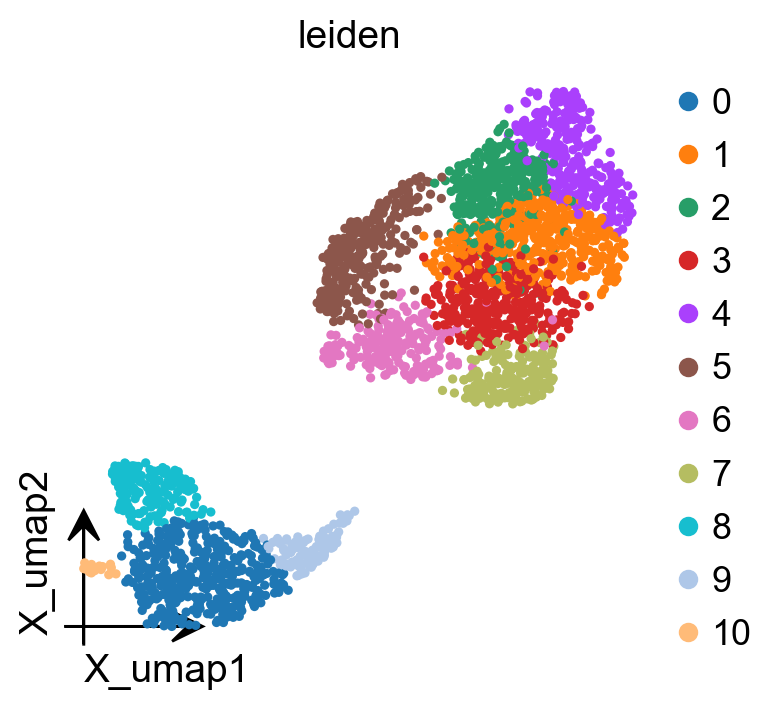

UMAP computed and plotted colored by 'leiden'.
❌ Error executing generated code: name 'pre_cells' is not defined
Code that failed: import omicverse as ov
if 'neighbors' not in adata.uns:
    if 'X_pca' in adata.obsm:
        ov.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
    else:
        ov.pp.neighbors(adata, n_neighbors=15)
ov.pp.umap(adata)
ov.pl.embedding(adata, basis='X_umap', color='leiden')
print("UMAP computed and plotted colored by 'leiden'.")
print(f"Dataset shape: {pre_cells} cells × {pre_genes} genes; UMAP basis stored in adata.obsm['X_umap'].")


AnnData object with n_obs × n_vars = 2700 × 16634
    obs: 'nUMIs', 'mito_perc', 'ribo_perc', 'hb_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'leiden'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'pca', 'neighbors', 'REFERENCE_MANU', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [12]:
# 1) Quality control, guided by single-preprocessing skill
adata = agent.run('follow the single-preprocessing skill: quality control with nUMI>500, mito<0.2', adata)

# 2) Preprocessing + HVGs
adata = agent.run('follow the single-preprocessing skill: preprocess with 2000 highly variable genes using shiftlog|pearson', adata)

# 3) Clustering
adata = agent.run('follow the single-preprocessing skill: leiden clustering resolution=1.0', adata)

# 4) UMAP + visualization (agent may also handle plotting)
adata = agent.run('follow the single-preprocessing skill: compute umap and plot colored by leiden', adata)

adata

## Manual visualization (optional)

If plotting wasn’t performed by generated code, visualize here.


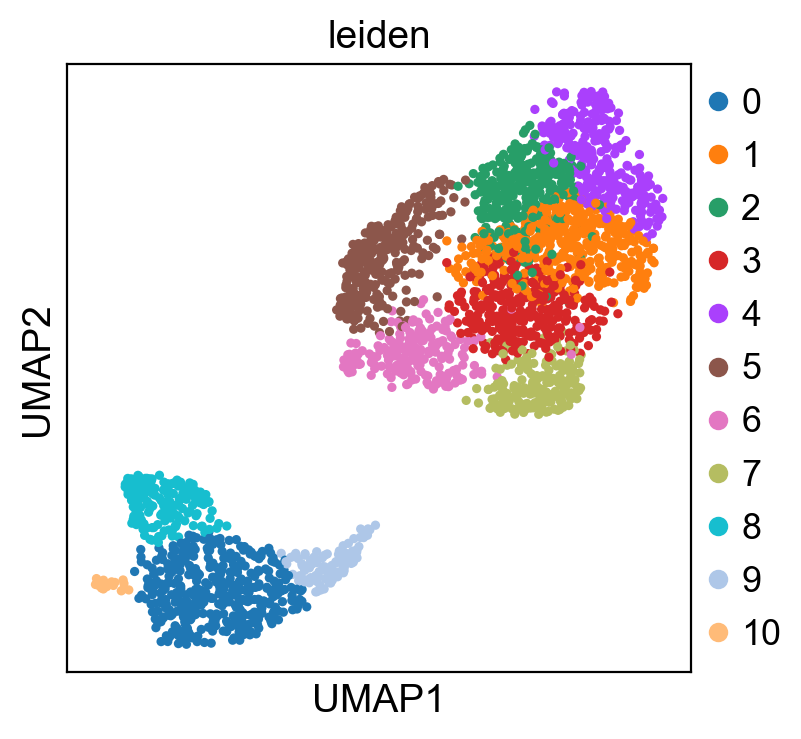

In [11]:
# Run leiden clustering
sc.tl.leiden(adata)

# Now plot the UMAP
sc.pl.umap(adata, color=['leiden'], wspace=0.4)

## (Optional) Create a skill from docs links

Use `ov.agent.seeker` to scaffold a new skill from documentation links (requires network).


In [ ]:
# Example: build a quick skill from a documentation link (uncomment to run)
# info = ov.agent.seeker(
#     ['https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html'],
#     name='hvg-guidance', target='output', package=False
# )
# info

## Next steps

- Adjust QC thresholds or clustering resolutions and re‑prompt the agent.
- Add cell‑type annotation via prompts (see Tutorials‑single for annotation notebooks).
- Customize `.claude/skills/` in your project to steer analysis with your lab’s SOP.
